# Neural Network Prediction of Sahelian Summer Rainfall
***

#### Resources:
* [Mardata Course](https://github.com/mardatade/Course-Python-for-Machine-Learning/blob/master/3.%20Neural%20Network.ipynb)
* [Keras for Data Scientists](https://keras.io/getting_started/intro_to_keras_for_engineers/#data-loading-amp-preprocessing)

In [98]:
import numpy as np
import pandas as pd 
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as st

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.utils import shuffle
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import tensorflow_addons as tfa
from tensorboard.plugins.hparams import api as hp
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<br>
<br>

## 1. Data Loading & Preprocessing
***

<br>

### a) Loading & Normalization

**pred:** contains the data used for the inputs  <br>
**label:** from Sahelrainfall data serves as validation data

In [5]:
pred = xr.open_dataset('data/da_pred_all.nc').to_dataframe()

pred_unit = pd.DataFrame(
    data = StandardScaler().fit_transform(pred), 
    columns = pred.columns,
    index =  pred.index
)


# load validatoin data (Summer Rainfall over Sahel) 
labels = np.mean(np.loadtxt("data/da_o_sahelprecip19012017.txt", skiprows=8,)[:,7:10] * 0.01,  axis=1)

labels = np.squeeze(StandardScaler().fit_transform(np.reshape(labels, (117,1))))


In [6]:
labels.std()

0.9999999999999999

In [7]:
pred_unit.head()

,siod_e,siod_w,sst_med,tsa,tna,sst_mdr,sata_lnh,sata_lsh,sata_onh,sata_osh,slp_darwin,slp_tahiti,amo,nao,pdo,np,nino12,nino3,nino34,nino4
year,,,,,,,,,,,,,,,,,,,,
1901,-1.100027,-1.152764,-0.745530,-0.595366,0.388372,0.608415,-0.123443,-0.732091,-0.497808,-0.737797,0.074807,1.634819,0.923204,0.917456,-0.193321,1.938388,-0.950168,-0.595561,-0.214314,-0.079270
1902,0.088643,0.340415,-1.507314,-0.954566,-0.346586,-0.173588,-1.289978,-0.201810,-1.175314,-0.987096,1.443896,2.682485,-0.620146,-1.172590,0.819716,-0.162154,0.991321,0.969845,1.099218,1.070532
1903,-0.900789,0.669332,-2.243639,-2.186294,-0.101970,0.283583,-1.333183,-1.076056,-1.415719,-1.333946,-0.071881,1.535042,-0.458290,-1.030410,-0.186187,0.530864,-0.371251,0.000784,0.524139,0.842095
1904,-0.949568,-1.056219,-0.079925,-1.975498,-2.214111,-1.894743,-1.135674,-1.133384,-1.863746,-1.778347,-0.903114,1.235708,-1.872482,1.447076,-0.892459,0.756497,-0.307712,-0.234313,-0.475713,-0.741738
1905,-0.034350,-0.632249,-0.718895,-1.684676,-1.334312,-1.014906,-1.314666,-0.595938,-1.284589,-0.954579,0.759351,-2.655622,-0.499163,-1.289888,0.545055,-0.326007,1.227830,1.497381,1.439037,1.032459


<br>

### b) PCA

### **Question:** normalize pcs again? --> See : [Data loading & preprocessing](https://keras.io/getting_started/intro_to_keras_for_engineers/#data-loading-amp-preprocessing) 
variance is non-unit for now...\
or does another normalization clear out the information of the pcs?
Badr did not mention anything like that.

In [8]:
# Scikit pca transformation
pca = PCA()
principalComponents = pca.fit_transform(pred_unit)


# Create Create Pandas DF from PCs
col = []
for i in range(1, 21):
    col.append(f'PC{i}')

pred_pc = pd.DataFrame(
    data = principalComponents,
    columns = col,
    index =  pred.index
)

pred_pc = pd.DataFrame(
    data = StandardScaler().fit_transform(pred_pc), 
    columns = pred_pc.columns,
    index =  pred_pc.index
)

# Test for unit-variance and zero mean:
print(np.std(pred_pc))
print(np.mean(pred_pc))
# pred_pc.head()

PC1     1.0
PC2     1.0
PC3     1.0
PC4     1.0
PC5     1.0
PC6     1.0
PC7     1.0
PC8     1.0
PC9     1.0
PC10    1.0
PC11    1.0
PC12    1.0
PC13    1.0
PC14    1.0
PC15    1.0
PC16    1.0
PC17    1.0
PC18    1.0
PC19    1.0
PC20    1.0
dtype: float64
PC1     1.973730e-16
PC2     3.510962e-17
PC3     5.930679e-17
PC4    -2.846726e-18
PC5     4.744543e-19
PC6    -3.795634e-17
PC7     3.795634e-18
PC8    -2.324826e-17
PC9     6.642360e-17
PC10   -1.470808e-17
PC11   -2.656944e-17
PC12   -1.138690e-17
PC13    1.550872e-17
PC14   -1.518254e-17
PC15    1.138690e-17
PC16    1.423363e-17
PC17    2.182490e-17
PC18   -3.705562e-17
PC19   -1.613145e-17
PC20   -1.802926e-17
dtype: float64


<br>

### c) Select PCs for input and turn into numpy array

In [9]:
features = pred_pc.to_numpy() #.loc[:,['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC13']]
features.shape

(117, 20)

<br>
<br>

## 2. Build Model
***

### **Question:** Badr says in Table2: '**standard* correlation and error meassures'? --> means standard or standardized?

<br>

## a) RRHCV


### 1.) Define Model

In [10]:
def Buildmodel(HPARAMS):
    model = keras.Sequential([
#         layers.Dropout(0.1, input_shape=(20,)),
        layers.Dense(HPARAMS['layersize'], HPARAMS['activation'] ,name="layer1"),
        layers.Dropout(HPARAMS['dropout_rate']),
        
        layers.Dense(HPARAMS['layersize'], HPARAMS['activation'], name="layer2"),
        layers.Dropout(HPARAMS['dropout_rate']),
        
        layers.Dense(HPARAMS['layersize'], HPARAMS['activation'], name="layer3"),
        layers.Dropout(HPARAMS['dropout_rate']),
        
        layers.Dense(HPARAMS['layersize'], HPARAMS['activation'], name="layer4"),
        layers.Dropout(HPARAMS['dropout_rate']),
        
        layers.Dense(HPARAMS['layersize'], HPARAMS['activation'], name="layer5"),
        layers.Dropout(HPARAMS['dropout_rate']),
        
#         layers.Dense(HPARAMS['layersize'], HPARAMS['activation'], name="layer6"),
#         layers.Dropout(HPARAMS['dropout_rate']),
        
        layers.Dense(1, name='output'), #activation='linear'
    ])
    model.compile(
        loss='mean_squared_error',
        optimizer=keras.optimizers.Adam(
            learning_rate=HPARAMS['learn_rate']
        )
    )
    return model

<br>

### 2.) Train model
* Perfrom in total k Repetitions
* For each walkthrough the data is first shuffled and the split into training (90%) and test (10%) sets.
* save single error metrics () into numpy array 
* **set parameters at top of cell**

In [192]:
### choose parameters ###
HPARAMS = {
    'activation': 'relu',
    'optimizer': 'Adam',
    'learn_rate': 0.02,
    'batch_size': 48.0,
    'n_epochs': 200,
    'dropout_rate': 0.1,
    'layersize': 11.4,
    
}

earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)



k = 5 # number of 'folds' -> sample size as in Badr
test_frac = .1 # factrion that is held out for testing

In [193]:
labels[train_index].shape

(93,)

In [194]:
# tf.keras.callbacks.History?
len(train_history.history['loss'])

62

In [195]:
%%time

# define error metrics:
mae_train = []
mad_train = []
mse_train = []
rmse_train = []
corr_train = []

mae_test = []
mad_test = []
mse_test = []
rmse_test = []
corr_test = []

training_length = []

# use sklearn Shuffle Split to Lood through Cross-Validation
# for train_index, test_index in ShuffleSplit(n_splits=k, test_size=test_frac).split(features):      #RRHCV
for train_index, test_index in KFold(n_splits=k, shuffle=True).split(features):                      #KFold

    train_index = shuffle(train_index)
    test_index  = shuffle(test_index)
    
    print("TRAIN:", train_index, "TEST:", test_index)
    
    # Build the model according to definition:
    model = Buildmodel(HPARAMS)
    
    #Train the model 
    train_history = model.fit(
        features[train_index],
        labels[train_index],
        batch_size=HPARAMS['batch_size'],
        epochs=HPARAMS['n_epochs'],
        verbose=2,
        callbacks=earlystop
    )
    
    #Run the model for insample data:
    y_train= np.squeeze(model.predict(features[train_index]))
    
    # ... and for out of sample data
    y_test = np.squeeze(model.predict(features[test_index]))
    
    
    # save errors into numpy arrays:
    e_train =  y_train - labels[train_index]
    ae_train = np.absolute(e_train)
    mae_train = np.append(mae_train, np.mean(ae_train))
    mad_train = np.append(mad_train, np.median(np.absolute(e_train - np.median(e_train))))
    mse_train = np.append(mse_train, np.mean(e_train**2))
    rmse_train = np.append(rmse_train, np.sqrt(mse_train))
    corr_train = np.append(corr_train, st.pearsonr(y_train, labels[train_index])[0])
    
    
    e_test =  y_test - labels[test_index]
    ae_test = np.absolute(e_test)
    mae_test = np.append(mae_test, np.mean(ae_test))
    mad_test = np.append(mad_test, np.median(np.absolute(e_test - np.median(e_test))))
    mse_test = np.append(mse_test, np.mean(e_test**2))
    rmse_test = np.append(rmse_test, np.sqrt(mse_test))
    corr_test = np.append(corr_test, st.pearsonr(y_test, labels[test_index])[0])
    
    training_length = np.append(training_length, len(train_history.history['loss']))

TRAIN: [ 33   8 100  79 113  77  29  36  80 104  34  32 102  16 114  90  62   2
  89  18  30  14 107  10  66  49  69  47  64  58  96  52  38  83  68   4
  88  40 116 101  71  54 111  56  86  61  55  25  72   7  37  76 105  70
  20  84 115   6 106  59  17  85 103  22   5  60  44  99  19   0  57  94
 108  15  92  28  46  39  93  31  74  50  87   1  98 110 112  13  43  11
  78  67  75] TEST: [ 21  26  45   3  48  63   9  41 109  24  65  23  35  81  97  42  82  51
  53  27  91  12  95  73]


TypeError: Expected int32 passed to parameter 'size' of op 'Slice', got [48.0] of type 'list' instead. Error: Expected int32, got 48.0 of type 'float' instead.

In [170]:
model.summary()

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 11)                231       
_________________________________________________________________
dropout_395 (Dropout)        (None, 11)                0         
_________________________________________________________________
layer2 (Dense)               (None, 11)                132       
_________________________________________________________________
dropout_396 (Dropout)        (None, 11)                0         
_________________________________________________________________
layer3 (Dense)               (None, 11)                132       
_________________________________________________________________
dropout_397 (Dropout)        (None, 11)                0         
_________________________________________________________________
layer4 (Dense)               (None, 11)              

In [182]:
np.around(np.random.uniform(0,-4))

-3.0

In [127]:
corr_train

array([0.96386181, 0.95713346, 0.94969019, 0.96485913, 0.93089603])

In [128]:
corr_test

array([0.26596601, 0.52083329, 0.406725  , 0.46399705, 0.28412639])

In [129]:
mse_train

array([0.11428058, 0.15476576, 0.19493965, 0.11779739, 0.19540883])

In [130]:
mse_test

array([0.97244232, 0.943371  , 1.10380464, 1.01288754, 0.76737255])

In [131]:
train_history

<br>

### 3.) Error Computation

#### Training Errors

In [133]:
train_errors = pd.DataFrame(
    data = {
        'corr_mu': [np.mean(corr_train)],
        'corr_sig': [np.std(corr_train)],
        'mad_mu': [np.mean(mad_train)],
        'mad_sig': [np.std(mad_train)],
        'mae_mu': [np.mean(mae_train)],
        'mae_sig': [np.std(mae_train)],
        'mse_mu': [np.mean(mse_train)],
        'mse_sig': [np.std(mse_train)],
        'rmse_mu': [np.mean(rmse_train)],
        'rmse_sig': [np.std(rmse_train)],
        'training_length_mu': [np.mean(training_length)],
        'training_length_sig': [np.std(training_length)],
    }
)
train_errors

,corr_mu,corr_sig,mad_mu,mad_sig,mae_mu,mae_sig,mse_mu,mse_sig,rmse_mu,rmse_sig,training_length_mu,training_length_sig
0,0.953288,0.012449,0.230491,0.025857,0.298164,0.035054,0.155438,0.03541,0.381128,0.042745,64.2,10.225458


<br>

#### Test Errors

In [134]:
test_errors = pd.DataFrame(
    data = {
        'corr_mu': [np.mean(corr_test)],
        'corr_sig': [np.std(corr_test)],
        'mad_mu': [np.mean(mad_test)],
        'mad_sig': [np.std(mad_test)],
        'mae_mu': [np.mean(mae_test)],
        'mae_sig': [np.std(mae_test)],
        'mse_mu': [np.mean(mse_test)],
        'mse_sig': [np.std(mse_test)],
        'rmse_mu': [np.mean(rmse_test)],
        'rmse_sig': [np.std(rmse_test)],
    }
)
test_errors

,corr_mu,corr_sig,mad_mu,mad_sig,mae_mu,mae_sig,mse_mu,mse_sig,rmse_mu,rmse_sig
0,0.38833,0.099451,0.543991,0.09688,0.747708,0.071343,0.959976,0.110466,0.990428,0.041662


<br>

### 4.) PLot model output vs Validation Data

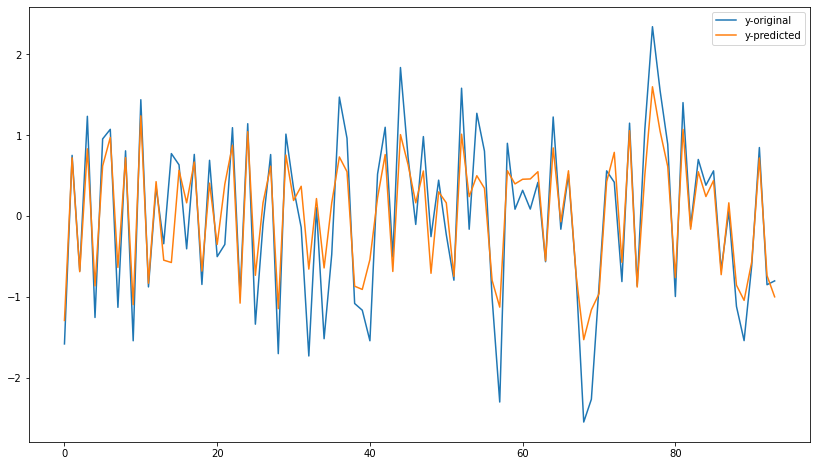

In [135]:
plt.figure(figsize=(14,8))
plt.plot(labels[train_index], label="y-original")
plt.plot(y_train, label="y-predicted")
plt.legend()
plt.show()

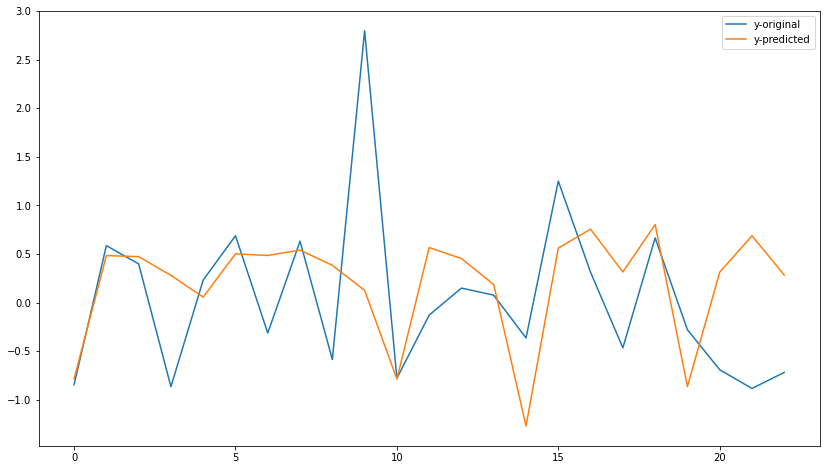

In [136]:
plt.figure(figsize=(14,8))
plt.plot(labels[test_index], label="y-original")
plt.plot(y_test, label="y-predicted")
plt.legend()
plt.show()

stopped attempt of funcitonaizing error computation

In [24]:
dict =	{
    "mae_train": [],
    'mad_train': [],
    'mse_train': [],
    'rmse_train': [],
    'corr_train': []
}


dict['mae_train'] = np.append (dict['mae_train'], 1)

def errors (string):
    
    dict[f'mae_{string}'] = np.append (dict[f'mae_{string}'], np.mean(ae_test))
    dict[f'mad_{string}'] = np.append(f'mad_{string}', np.median(np.absolute(e_train - np.median(e_train))))
    dict[f'mse_{string}'] = np.append(f'mse_{string}', np.mean(e_train**2))
    dict[f'rmse_{string}'] = np.append(f'rmse_{string}', np.sqrt(mse_train))
    dict[f'corr_{string}'] = np.append(f'corr_{string}', st.pearsonr(y_train, labels[train_index])[0])


In [184]:
# Learining Rate

10**np.random.uniform(0,-4,100)

array([6.10804775e-01, 2.47696360e-01, 1.67241406e-04, 3.11318523e-03,
       4.53473967e-02])

In [186]:
# Number of hidden units

np.random.uniform(5,15,10)

array([ 6.26513501,  9.9255531 ,  7.1490117 ,  8.17054186,  7.63275347,
       12.29635719, 12.64338287,  9.08567385,  8.52927191, 13.99021751])

In [198]:
# Batch Size

(10**np.random.uniform(0.6,2,10)).astype(int)

array([52,  4, 15, 48,  9,  6,  8, 46, 97, 81])

In [201]:
Dropout
10**np.random.uniform(-0.3,-1.3,20)

array([0.14208426, 0.30180674, 0.30691002, 0.17595049, 0.12737998,
       0.09987594, 0.41145303, 0.08510185, 0.03847942, 0.05337334,
       0.14445748, 0.17091705, 0.26699635, 0.05538397, 0.03798144,
       0.07464967, 0.12521963, 0.13869433, 0.05517833, 0.44645414])